
<image src="https://raw.githubusercontent.com/ramiro999/depth-passive-sesion4/main/images/cover-page.png" width=100%>


# <center> **05. Estimación pasiva de la profundidad** </center>

La estimación pasiva de la profundidad es el conjunto de técnicas y algoritmos para estimar la distancia observada de objetos para permitir una comprensión tridimensional (3D) del entorno circundante. Durante esta sesión vamos a aplicar los conceptos explicados, **para estimar la disparidad en imágenes estéreo prediseñadas mediante diversas técnicas de programación y así obtener los mapas de disparidad y profundidad.**

## **Contenido**

[**1. Introducción a la visión estéreo**](#tema1)

[**2. Profundidad y Disparidad**](#tema2)

[**3. Calibración de camaras**](#tema3)

[**4. Geometría epipolar**](#tema4)

[**5. Rectifcación**](#tema5)

[**6. Coincidencia estéreo**](#tema6)

[**7. Triangulación y Reconstrucción 3D**](#tema7)

In [1]:
#@title **Cargar librerias**
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2 as cv
from PIL import Image
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)
import sys
sys.path.append("..")


In [2]:
#@title **Montar drive**
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#@title **Moverse a la carpeta donde guardaron el noteboook**
%cd "/content/drive/MyDrive/depth-passive-sesion4"

/content/drive/MyDrive/depth-passive-sesion4


## <font color='#4C5FDA'>**1. Introducción a la visión estéreo**</font> <a name="tema1">




<font color="EB9A54"> **Visión estéreo** </font> es la técnica de estimación pasiva de la profundidad que se basa en la extracción de información 3D por computación (profundidad, forma, tamaño y ubicación de objetos en el espacio) proveniente de imagenes digitales de multiples escenas, como las obtenidas por una camara CCD. Este enfoque se utiliza en múltiples aplicaciones, como sistemas de asistencia al conductor, navegación robótica, mapeo de escenas, inferencia de profundidad para entretenimiento y, en general, cualquier aplicación donde la profundidad de los objetos en la escena sea una información valiosa.

<div align="center"> <image src="https://raw.githubusercontent.com/ramiro999/depth-passive-sesion4/main/images/vision-stereo-1.png" width=600>  </div>








<font color="EB9A54">**Sistema de visión estéreo estandar**</font>

Al tener múltiples imágenes de una escena, es posible crear un mapa 3D de esa escena utilizando técnicas de visión estéreo. Esto no requiere dos cámaras, sino dos vistas diferentes de la escena. En este sentido, tenemos diferentes posibilidades:

- Dos camaras.
- Imágenes tomadas simultáneamente.
- Se conoce la pose relativa de las cámaras.

<div align="center"> <image src="https://raw.githubusercontent.com/ramiro999/depth-passive-sesion4/main/images/sistema_estereovision.png" width=600>  </div>



<font color="EB9A54">**Reconstrucción de escena usando visión estéreo**</font>

Al tener dos cámaras separadas, podemos reconstruir una escena **(obtener un mapa 3D a tamaño real)** conociendo la disparidad de cada punto y los parámetros intrínsecos de la cámara:

<div align="center"> <image src="https://raw.githubusercontent.com/ramiro999/depth-passive-sesion4/main/images/our_depth_demo.gif" width=600>  </div>

Ahora sabemos que el objetivo de la visión estéreo es recuperar información 3D a partir de imágenes 2D. Un objetivo ambicioso, ¿no?


<font color="EB9A54">**Modelo de visión estéreo**</font>

Conoce el siguiente modelo que describe de los pasos claves de visión estéreo.

<div align="center"> <image src="https://raw.githubusercontent.com/ramiro999/depth-passive-sesion4/main/images/metodologia.png" width=800>  </div>


- <font color= "52F17F"> **Calibración:**  </font> La calibración de la cámara se refiere tanto a la intrínseca como a la extrínseca. La calibración intrínseca determina el centro de la imagen, la distancia focal y los parámetros de distorsión, mientras que la calibración extrínseca determina las posiciones 3D de las cámaras. Este es un paso crucial en muchas aplicaciones de visión artificial, sobre todo cuando se requiere información métrica de la escena, como la profundidad.

- <font color="52F17F"> **Rectificación:** </font> La rectificación estéreo se refiere al proceso de reproyección de los planos de la imagen en un plano común paralelo a la línea entre los centros de las cámaras. Tras la rectificación, los puntos correspondientes se encuentran en la misma fila, lo que reduce en gran medida el coste y la ambigüedad del emparejamiento.

- <font color="52F17F"> **Emparejamiento estéreo:** </font> Se refiere al proceso de emparejamiento de píxeles entre las imágenes izquierda y derecha, que genera imágenes de disparidad. El algoritmo de coincidencia semiglobal (SGM) es uno de los más utilizados.

- <font color="52f17f"> **Triangulación:**</font> La triangulación se refiere al proceso de determinar un punto en el espacio 3D dada su proyección en las dos imágenes. La imagen de disparidad se convertirá en una nube de puntos 3D.

## <font color="EB9A54"> **Prueba 1:** </font> En un caso ideal, se capturan imágenes estéreo que han sido calibradas y rectificadas.

- Carga las imagenes del dataset `motorcycle` disponible en la carpeta de datos.
- Visualiza las imagenes
- ¿Ambas imagenes son diferentes o iguales?


(-0.5, 2963.5, 1999.5, -0.5)

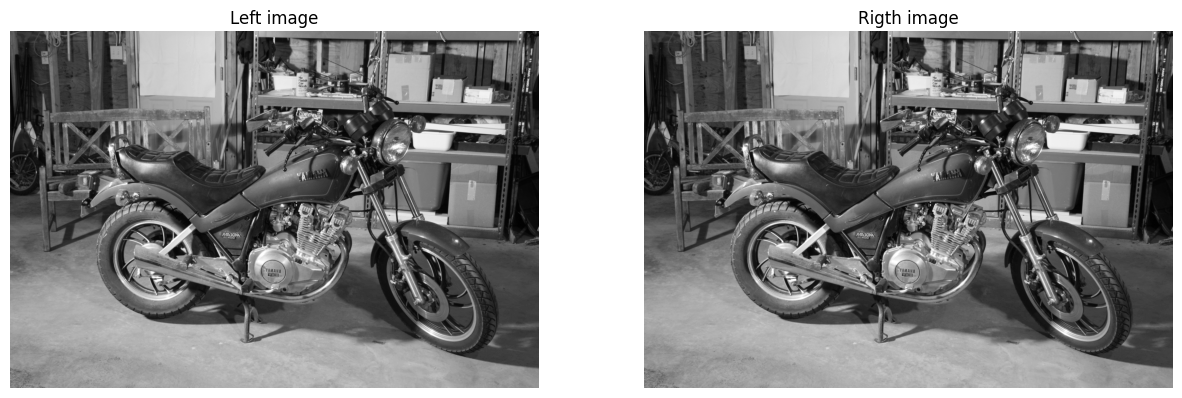

In [4]:
# Carga las imagenes en escala de grises

"""Pon tu código aquí"""
imgL = "./datasets/motorcycle/imL.png"
imgR = "./datasets/motorcycle/imL.png"

left_image_path = cv.imread(imgL, cv.IMREAD_GRAYSCALE)
rigth_image_path = cv.imread(imgR, cv.IMREAD_GRAYSCALE)

# Visualiza ambas imagenes

"""Pon tu código aquí"""

plt.figure(figsize=(15,9))
plt.subplot(1, 2, 1)
plt.imshow(left_image_path, cmap= 'gray')
plt.title('Left image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rigth_image_path, cmap= 'gray')
plt.title('Rigth image')
plt.axis('off')



## <font color='#4C5FDA'>**2. Disparidad y Profundidad**</font> <a name="tema2">


Hasta el momento hemos hablado de disparidad y profundidad, pero <font color= "52F17F" >**¿Queda claro el significado de ambos terminos?**</font>

✅ Veamoslo:

<font color = "EB9A54"> **Disparidad** </font>

En los seres humanos, la percepción visual de la estructura tridimensional es realizada por el sistema visual humano, mediante los ojos y el cerebro. Dada la posición
de los ojos, las imágenes que éstos presentan al cerebro son prácticamente idénticas salvo por una cierta diferencia en la posición relativa de los objetos en dichas imágenes.
A esta diferencia relativa se le denomina disparidad, y tiene una relación directa con la distancia (profundidad) a la que se encuentran los objetos entre sí y respecto del
observador. El cerebro es capaz de interpretar esa diferencia y reconstruir la estructura tridimensional de la escena que se está observando. El problema de la correspondencia estéreo trata por tanto de dar solución a ese mismo rompecabezas que el cerebro resuelve automáticamente de forma tan aparentemente sencilla.

En resumen, **la disparidad** es una medida fundamental en la visión estéreo que permite la percepción de profundidad. En otras palabras, se refiere a la diferencia en la posición horizontal de pixeles correspondientes a la imagenes izquierda y derecha.

$$ \color{orange} {d = X_l - X_d} $$

donde $\mathbf{d}$ es la disparidad, $\mathbf{X_l}$ es la posición horizontal de puntos en la camara izquierda y $\mathbf{X_d}$ es la posición horizontal de puntos en la cámara derecha.

Los algoritmos destinados a obtener el mapa de disparidad de una imagen, se
denominan algoritmos de correspondencia estéreo, y pueden ser clasificados,
fundamentalmente, en dos grandes grupos:
- Basados en área
- Basados en coincidencia de características

<font color = "EB9A54"> **Profundidad** </font>

Se entiende por profundidad a la distancia a la que se encuentran los objetos entre sí y respecto de las camaras.

$$\color{orange}  {Z = \frac{fB}{d}} $$

donde $\mathbf{Z}$ es la profundidad, $\mathbf{f}$ es la distancia focal, $\mathbf{B}$ es la linea de base, y $\mathbf{d}$ es la disparidad.


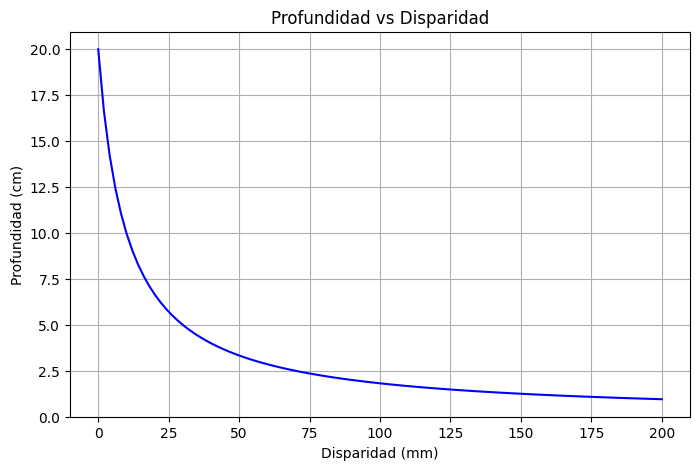

In [5]:
#@title Por ende la profundidad es inversamente proporcional a la disparidad

disparidad = np.linspace(0, 200, 100) # Disparidad de 0 a 200
profundidad = 1 / (0.005 * disparidad + 0.05) # Relacion inversamente proporcional

# Plotting the data
plt.figure(figsize=(8, 5))
plt.plot(disparidad, profundidad, label='Profundidad Real', color='blue')
plt.title('Profundidad vs Disparidad')
plt.xlabel('Disparidad (mm)')
plt.ylabel('Profundidad (cm)')
plt.grid(True)
plt.show()

## <font color="EB9A54"> **Prueba 2:** </font> Aplicación de la visión estéreo y cálculo del mapa de disparidad

- Carga las imagenes del dataset `tsukuba` disponible en la carpeta de datos.
- Utiliza la función `cv.StereoBM_create` para crear un objeto de coincidencia de bloques stereo.
- Calcula el mapa de disparidad para las imagenes con la función `compute`
- Utiliza una metrica de valor medio para calcular la disparidad del mapa.
- Visualiza las imagenes y el mapa de disparidad

84.13225188078704


Text(0.5, 1.0, 'Disparity map')

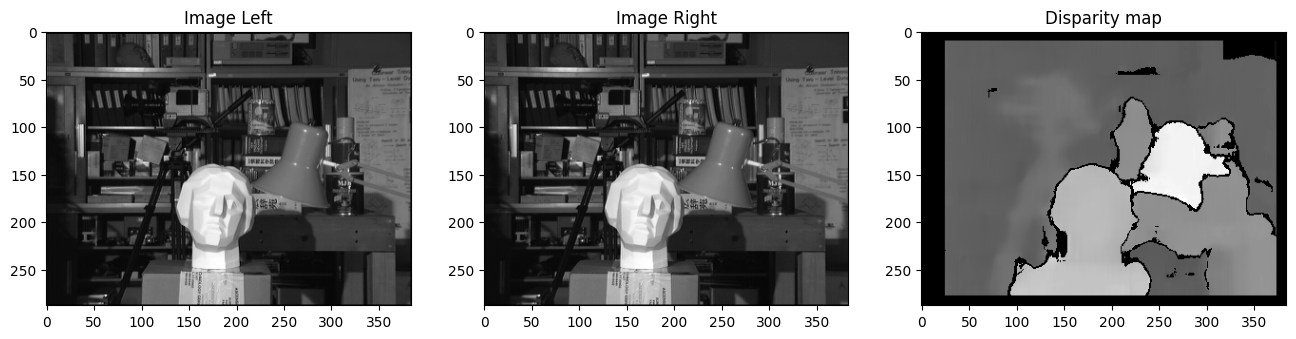

In [6]:
# Carga las imagenes en escala de grises.

"""Pon tu código aquí"""
left_image_path = "./datasets/tsukuba/imL.png"
right_image_path = "./datasets/tsukuba/imR.png"

imgL = cv.imread(left_image_path, cv.IMREAD_GRAYSCALE)
imgR = cv.imread(right_image_path, cv.IMREAD_GRAYSCALE)

# Aplica la función cv.StereoBM_create.

"""Pon tu código aquí"""
stereo = cv.StereoBM_create(numDisparities = 16, blockSize=21)

# Aplica la función compute.

"""Pon tu código aquí"""
disparity_map = stereo.compute(imgL, imgR)

# Metrica de valor medio.

"""Pon tu código aquí"""
mean_disparity = np.mean(disparity_map)
print(mean_disparity)
# Visualiza las imagenes y el mapa de disparidad

"""Pon tu código aquí"""
plt.figure(figsize=(16,9))

plt.subplot(1,3,1)
plt.imshow(imgL, cmap='gray')
plt.title("Image Left")

plt.subplot(1,3,2)
plt.imshow(imgR, cmap='gray')
plt.title("Image Right")

plt.subplot(1,3,3)
plt.imshow(disparity_map, cmap='gray')
plt.title('Disparity map')

Estos resultados son obtenidos de imagenes estereó que sean proporcionando con calibración de camara. <font color= "52F17F" > **¿Que sucede si las imagenes proporcionado no provienen de un sistema calibrado? Veamoslo en la siguiente sección.** </font>

## <font color='#4C5FDA'>**3. Calibración de camara**</font> <a name="tema3">


Supongamos que visitas un monumento y tomas una fotografia y algun tiempo despues un amigo visita el mismo monumento y toma otra fotografia, no tenemos idea de donde fueron tomadas las fotos, pero resulta que si conocemos los parámetros internos de las dos cámaras, entonces, a partir de estas dos vistas arbitrarias, puedes calcular la rotación y traslación de una camara con respecto a la otra. Y una vez hecho esto, podras calcular un modelo tridimensional del monomunemento. Este el problema de los sistemas no calibrados.

<image src='https://raw.githubusercontent.com/ramiro999/depth-passive-sesion4/main/images/camera-calibration.png' >

Como vimos anteriormente, la calibración de camara considera los valores intrínsecos y extrínsecos para estimar una matriz de proyección

<font color='EB9A54'>**Valores intrínsecos**</font>

Estos valores describen las características internas de la cámara y cómo las imágenes son formadas por el sistema óptico de la misma.

- <font color='52F17F'>**Centro optico:** </font> El centro óptico, también conocido como el punto principal de la imagen, se refiere a las coordenadas $\mathbf{(O_x, O_y)}$  en el plano de la imagen (el sensor de la cámara), donde el eje óptico intersecta el plano. Este punto es esencial para la calibración de la cámara y para la conversión de coordenadas entre el mundo real y la imagen.

- <font color='52F17F'> **Distancia focal:** </font> La distancia focal $\mathbf{(F_x, F_y)}$  se refiere a la distancia entre el centro óptico de la lente y el plano de la imagen, expresada en términos de píxeles.


- <font color='52F17F'> **Parametros de distorsión:** </font> Los parámetros de distorsión describen cómo la luz que entra en la cámara se desvía de una proyección ideal debido a imperfecciones en el sistema óptico de la cámara. Estas distorsiones pueden hacer que las líneas rectas en el mundo real aparezcan curvas en la imagen, o que los objetos parezcan más grandes o más pequeños de lo que deberían ser. Los tipos más comunes de distorsión son:

  1. Distorsión Radial
  2. Distorsión Tangencial

<font color='EB9A54'>**Valores extrínsecos**</font>

Los valores extrínsecos de una cámara se refieren a la **traslación** y **orientación** de la cámara en un espacio tridimensional respecto a un sistema de coordenadas de referencia global. A diferencia de los valores intrínsecos, que son propiedades internas de la cámara y no cambian a menos que la configuración óptica de la cámara se modifique, los valores extrínsecos varían cada vez que la cámara se mueve.


🆗 Estos valores son fundamentales para la calibración de la cámara, un proceso que permite corregir las imágenes para eliminar o reducir estos efectos de distorsión, mejorando la precisión de la proyección de puntos 3D del mundo real a 2D en la imagen.

🎲 Y así estamos listos para calibrar la cámara, lo que es esencialmente significa estimar la matriz de proyección.

## <font color='#4C5FDA'>**4. Geometría epipolar**</font> <a name="tema4">

La geometría epipolar es el <font color='EB9A54'>**conjunto de restricciones geométricas entre dos vistas de una escena.** </font> Cuando dos cámaras capturan una escena 3D desde dos posiciones diferentes, hay una serie de relaciones geométricas entre los puntos 3D y sus proyecciones sobre las imágenes 2D que generan restricciones entre los puntos de la imagen. Estas relaciones se derivan del supuesto de que las cámaras pueden aproximarse mediante el modelo de cámara estenopeica (por ejemplo, sus imágenes no están distorsionadas).

<image src = "https://github.com/ramiro999/depth-passive-sesion4/blob/main/images/epipolar%20geometry.png?raw=true">

<font color='EB9A54'>**Contexto:** </font>

En la práctica, **la triangulación precisa no es completamente factible ya que los sistemas estéreo no cumplen con la configuración ideal**. Sin embargo, la buena noticia es que cualquier par de imágenes tomadas con cualquier configuración (siempre y cuando haya solapamiento entre las imágenes, por supuesto) puede ser transformado para que cumplan con una configuración ideal de cámara estéreo. Esto se denomina rectificación estéreo o rectificación de imagen.

<image src = "https://github.com/ramiro999/depth-passive-sesion4/blob/main/images/rectification.png?raw=true">



## <font color="EB9A54"> **Prueba 3:** </font> Lineas epipolares
Hasta el momento hemos encontrado el mapa de disparidad, sin embargo, en el estudio de visión estereo la geometria epipolar es el paso siguiente de la calibración, encontremos las lineas epipolares:

- Carga las imagenes en escala de grises e imprime el tamaño
- Utiliza las funciones  `ORB_create()` y `detectAndCompute()` para detectar y calcular descriptores de puntos clave en una imagen.
- Utiliza la clase `BFMatcher()` y `match` para que cada descriptor de puntos clave realice la comparación con todos los demás descriptores de puntos clave.

In [ ]:
# Cargar imagen izquierda
im_l = None
im_l = None

# Cargar imagen derecha
im_r = None
im_r = None

# Conversion a escala de grises
gray_l = None
gray_r = None

# Imprimir resultados


In [7]:
#@title Completado
im_l = cv.imread("/content/drive/MyDrive/depth-passive-sesion4/datasets/tsukuba/imL.png")  # queryimage
im_l = cv.cvtColor(im_l, cv.COLOR_BGR2RGB)

# Read right image
im_r = cv.imread("/content/drive/MyDrive/depth-passive-sesion4/datasets/tsukuba/imR.png")  # trainimage
im_r = cv.cvtColor(im_r, cv.COLOR_BGR2RGB)

# Get gray images
gray_l = cv.cvtColor(im_l,cv.COLOR_RGB2GRAY)
gray_r = cv.cvtColor(im_r,cv.COLOR_RGB2GRAY)

print("Image sizes:",gray_l.shape,"and",gray_r.shape)

Image sizes: (288, 384) and (288, 384)


In [ ]:
# Funcion ORB
orb = None

# Detectar puntos claves ORB y computar descriptores
kp_l, des_l = None
kp_l, des_l = None

# Coincidencia de descriptores
bf = None
matches = None

# Imprimir numero de coincidencias ORB


In [8]:
#@title Completado

orb = cv.ORB_create()

# -- detect ORB keypoints and compute descriptors
kp_l, des_l = orb.detectAndCompute(gray_l, None)
kp_r, des_r = orb.detectAndCompute(gray_r, None)

# Match descriptors.
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bf.match(des_l, des_r)

print("Number of ORB matches:", len(matches))

Number of ORB matches: 295


In [9]:
# Create lists of corresponding keypoints
pts_l = []
pts_r = []
for match in matches:
    pts_l.append(kp_l[match.queryIdx].pt)
    pts_r.append(kp_r[match.trainIdx].pt)

# Cast to integers no es necesario si vamos a usar findFundamentalMat, pues espera puntos flotantes
pts_l = np.float32(pts_l)
pts_r = np.float32(pts_r)

# Ahora debes pasar las listas pts_l y pts_r correctamente a findFundamentalMat
F, mask = cv.findFundamentalMat(pts_l, pts_r, cv.FM_RANSAC)

# keep only the inliers (matches)
matches_in = [matches[i] for i in range(len(matches)) if mask[i]]

# Aquí debes obtener nuevamente los puntos correspondientes a los inliers después de filtrar con la máscara
pts_l_in = [pts_l[i] for i in range(len(mask)) if mask[i]]
pts_r_in = [pts_r[i] for i in range(len(mask)) if mask[i]]

# Esta vez no necesitas castear a enteros, ya que los puntos deben ser en formato flotante
pts_l_in = np.float32(pts_l_in)
pts_r_in = np.float32(pts_r_in)

print("Number of inliers =", len(matches_in), "out of", len(matches))
print("Fundamental matrix =")
print(F)

Number of inliers = 283 out of 295
Fundamental matrix =
[[ 1.46355060e-20  5.75012770e-18 -9.35016206e-16]
 [-5.90623977e-18 -2.06929794e-19 -4.81970386e-02]
 [ 9.56464660e-16  4.81970386e-02 -1.15463195e-14]]


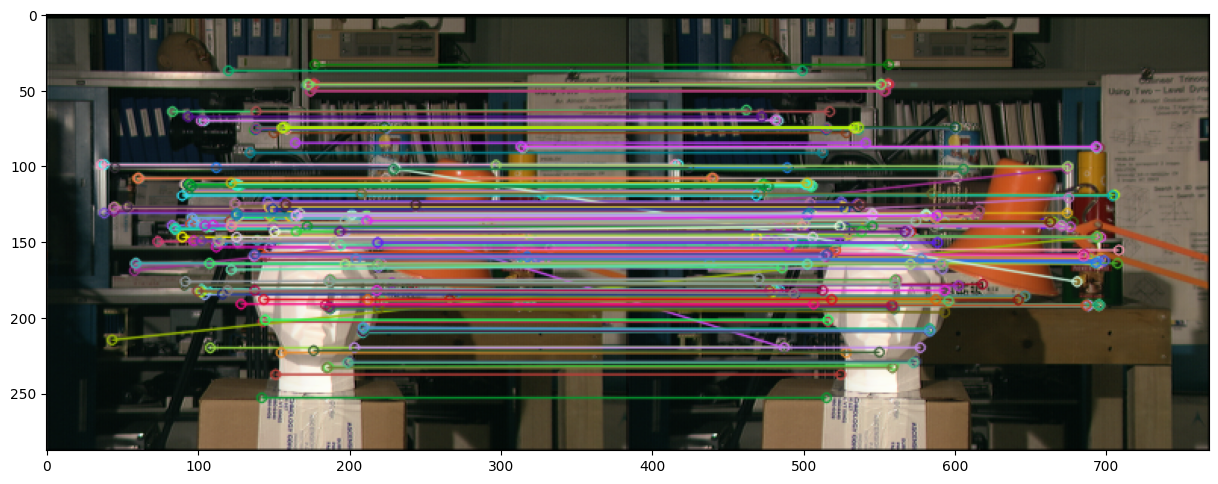

In [11]:
# Plot matches
matches_image = np.copy(im_l)
matches_image = cv.drawMatches(im_l, kp_l, im_r, kp_r, matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Mostrar la imagen usando matplotlib
plt.figure(figsize=(15,9))
plt.imshow(matches_image)
plt.show()

## <font color='#4C5FDA'>**5. Rectificación**</font> <a name="tema5">

Como se puede ver en las imágenes, las líneas epipolares no son horizontales. El proceso de rectificación estereoscópica proyecta las imágenes sobre un plano común, de forma que las líneas epipolares pasan a ser horizontales en ambas imágenes y a la misma altura, es decir, las transforma como si hubieran sido captadas en una configuración ideal, llevando los epipolos hasta el infinito.

Afortunadamente, existe el método cv2.stereoRectifyUncalibrated, que devuelve las homografías de rectificación para ambas imágenes dado un conjunto de puntos coincidentes y la matriz fundamental. Este método se utiliza cuando no se conoce la pose relativa de las cámaras que capturaron las imágenes (por ejemplo, dos imágenes tomadas con la misma cámara pero en posiciones diferentes).

## <font color="EB9A54"> **Prueba 4:** </font> Rectificación de imagenes
Anteriormente, implementamos las lineas epipolares, ahora hagamos la rectificación de imagenes:

- Utiliza la función `stereoRectifyUncalibrated` para calcular las matrices de rectificación.
- Utiliza la función  `warpPerspective()` para rectificar y aplicar la transformación de perspectivas de las imagenes.

- Plotea las imagenes en escala de colores RGB

In [ ]:
#  Matrices de rectificación
ret, H_l, H_r = None

# Aplicar la rectificación y transformación de perspectivas
rectified_l = None
rectified_r = None

# Mostrar imagenes originales y rectificadas
plt.subplot()
plt.title()
plt.imshow()

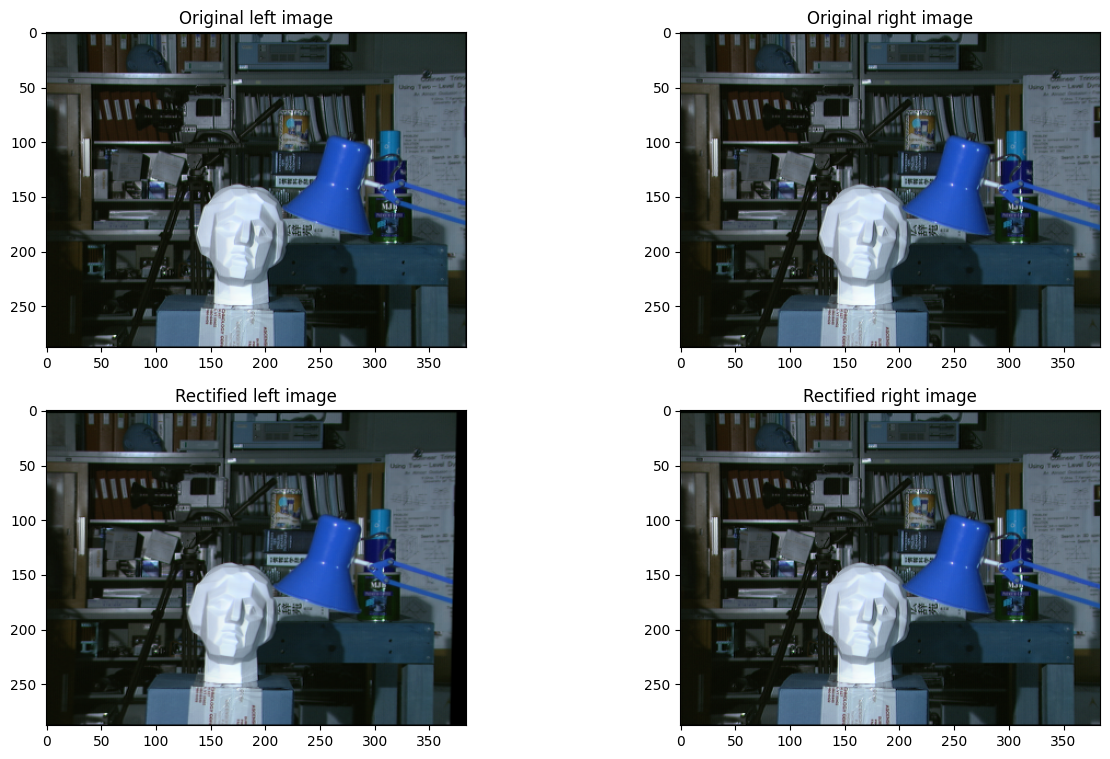

In [58]:
#@title Completado

# Configuración para mostrar las imágenes en Jupyter Notebook
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 20.0)

# ... (tu código anterior para obtener 'pts_l', 'pts_r', 'im_l', 'im_r', 'F') ...

# Se debe calcular las homografías usando los puntos correspondientes de los inliers y la matriz fundamental
# Si ya tienes una matriz F calculada y los puntos correspondientes pts_l y pts_r puedes utilizarlos aquí
ret, H_l, H_r = cv.stereoRectifyUncalibrated(np.float32(pts_l), np.float32(pts_r), F, im_l.shape[:2])

# Aplicar homografías para rectificar las imágenes
rectified_l = cv.warpPerspective(im_l, H_l, (im_l.shape[1], im_l.shape[0]))
rectified_r = cv.warpPerspective(im_r, H_r, (im_r.shape[1], im_r.shape[0]))

# Mostrar imágenes originales y rectificadas
plt.figure(figsize=(15,9))
plt.subplot(221)
plt.title("Original left image")
plt.imshow(cv.cvtColor(im_l, cv.COLOR_BGR2RGB))  # Convertir a RGB para mostrar correctamente

plt.subplot(222)
plt.title("Original right image")
plt.imshow(cv.cvtColor(im_r, cv.COLOR_BGR2RGB))  # Convertir a RGB para mostrar correctamente

plt.subplot(223)
plt.title("Rectified left image")
plt.imshow(cv.cvtColor(rectified_l, cv.COLOR_BGR2RGB))  # Convertir a RGB para mostrar correctamente

plt.subplot(224)
plt.title("Rectified right image")
plt.imshow(cv.cvtColor(rectified_r, cv.COLOR_BGR2RGB))  # Convertir a RGB para mostrar correctamente

plt.show()


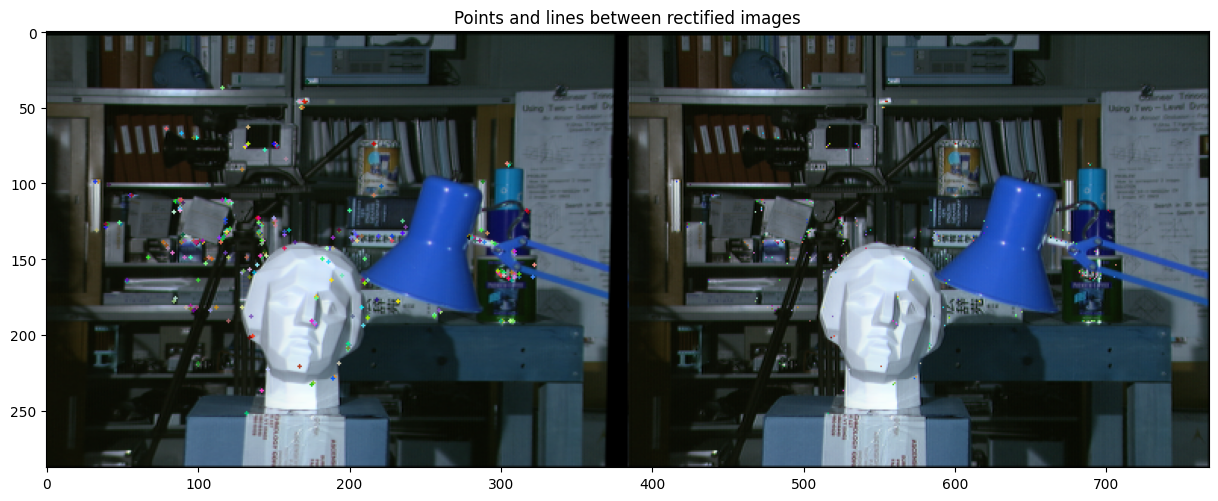

Number of points: 283
H_l = 
[[ 4.73003471e-02 -1.07937952e-03 -4.10643449e-02]
 [ 2.38629450e-14  4.81970386e-02  3.55271368e-14]
 [ 1.25210825e-16  1.26243479e-16  4.81970386e-02]]
H_r = 
[[ 1.00000000e+00  3.50661198e-15 -6.82121026e-13]
 [-3.50661198e-15  1.00000000e+00  5.11590770e-13]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [59]:

# Concatenar las imágenes rectificadas lado a lado
total = np.concatenate((rectified_l, rectified_r), axis=1)

# Tener en cuenta el desplazamiento de la imagen derecha al concatenar
_, offset = rectified_r.shape[:2]

# Configurar tamaño y contador
size = 1
cont = 0

# Dibujar círculos y líneas para puntos rectificados
for p in pts_l_in:  # Asegúrate de que estás usando 'pts_l_in', que es la lista de puntos de inliers después de la rectificación
    # Aplicar homografía izquierda
    hom_p = np.array([p[0], p[1], 1.0])  # Punto homogéneo
    tran_hom_p = H_l @ hom_p

    x = int(tran_hom_p[0] / tran_hom_p[2])
    y = int(tran_hom_p[1] / tran_hom_p[2])

    # Dibujar círculo en la imagen izquierda rectificada
    if y > 0:  # Verificar si y es positiva
        cont += 1
        color = tuple(np.random.randint(0, 255, 3).tolist())
        cv.circle(total, (x, y), size, color, -1)
        # Dibujar línea hacia la imagen derecha rectificada (puede requerir transformar el punto derecho también)
        cv.line(total, (x + offset, y), (x + offset, y), color, size)  # Esta línea asume que el punto 'y' es el mismo en ambas imágenes

plt.figure(figsize=(15,9))
plt.imshow(cv.cvtColor(total, cv.COLOR_BGR2RGB))  # Convertir a RGB para mostrar correctamente
plt.title("Points and lines between rectified images")
plt.show()

print("Number of points:", cont)

# Imprimir valores de homografías
print("H_l = ")
print(H_l)

print("H_r = ")
print(H_r)


In [17]:
def drawlines(im_points, pts, im_lines, lines, size=5):
    lines = lines.reshape(-1, 3)
    _, c = im_lines.shape[:2]
    for r, ptr in zip(lines, pts):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [c, -(r[2]+r[0]*c)/r[1]])
        im_lines = cv.line(im_lines, (x0, y0), (x1, y1), color, size)

        # Asegurarse de que ptr es una tupla de dos enteros antes de llamar a cv.circle
        x, y = int(ptr[0]), int(ptr[1])  # Ajusta esta línea si 'ptr' no está en el formato correcto
        im_points = cv.circle(im_points, (x, y), size, color, -1)
    return im_lines, im_points


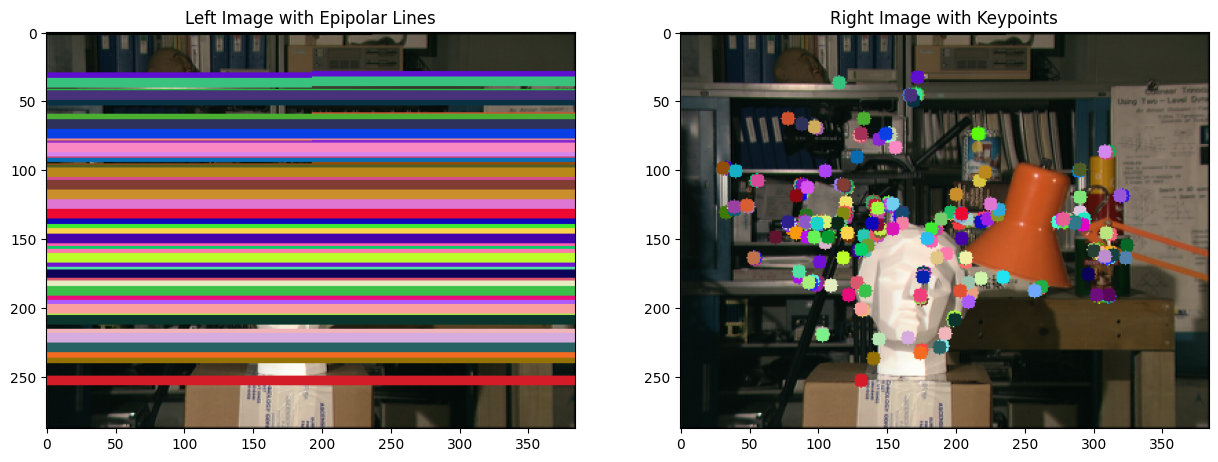

In [60]:
# Asegúrate de que pts_r es un conjunto de puntos detectados en la imagen derecha y F es la matriz fundamental.
lines_l = cv.computeCorrespondEpilines(pts_r.reshape(-1,1,2), 2, F)
lines_l = lines_l.reshape(-1,3)
# Asegúrate de que la función 'drawlines' está correctamente implementada como se discutió anteriormente.
epipolar_l, keypoints_im_r = drawlines(im_r, pts_r, im_l, lines_l, size=5)

# Mostrar la imagen izquierda con líneas epipolares.
plt.figure(figsize=(15,9))
plt.subplot(121)
plt.imshow(epipolar_l)
plt.title('Left Image with Epipolar Lines')

# Mostrar la imagen derecha con puntos de interés.
plt.subplot(122)
plt.imshow(keypoints_im_r)
plt.title('Right Image with Keypoints')
plt.show()


### <font color="EB9A54"> **Retroalimentación** </font>
¡Brillante! Nótese que si tuviéramos un sistema estereoscópico fijo, la matriz fundamental sería constante para cualquier par de imágenes. De todos modos, una vez aplicada la rectificación, la triangulación es más precisa, ¡y también lo sería el cálculo de la profundidad!

Durante este sección, hemos aprendido:
- Los fundamentos de la geometría epipolar
- Cómo realizar la rectificación estéreo para cámaras calibradas y no calibradas
- Cómo hallar la matriz fundamental a partir de un par de imágenes

## <font color='#4C5FDA'>**6. Coincidencia Estéreo**</font> <a name="tema6">

Ahora sobre la misma línea de exploración podemos encontrar los mismos píxeles en las imágenes izquierda y derecha que han captado el mismo punto de interés. Dado que el valor de un solo píxel no suele ser suficiente para encontrar el píxel correspondiente de forma fiable, normalmente intentamos hacer coincidir pequeñas ventanas (por ejemplo, 7x7 píxeles) alrededor de cada píxel con todas las ventanas posibles de la imagen derecha en la misma línea.

<img src = "https://raw.githubusercontent.com/ramiro999/depth-passive-session5/main/images/stereo_matching.png">

En las secciones de geometría epipolar y rectificación hicimos uso de coincidencias de pixeles en las imagenes, pero ahora debemos entender que  los algoritmos destinados a obtener el mapa de disparidad de una imagen, se
denominan algoritmos de coincidencia o correspondencia estéreo, y pueden ser clasificados, fundamentalmente, en dos grandes grupos:
- Basados en área
- Basados en coincidencia de características

3.258472583912037


Text(0.5, 1.0, 'Disparity map')

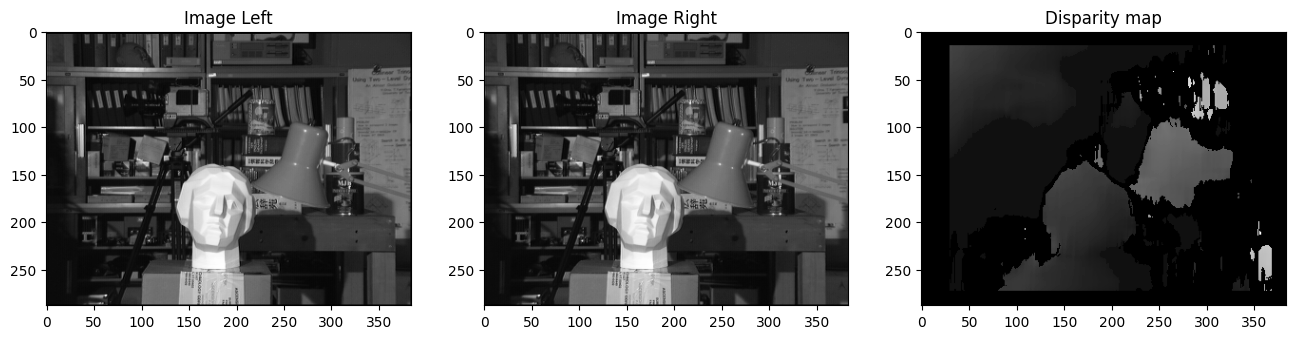

In [42]:
#@title Coincidencia estereo basada en area
# Carga las imagenes en escala de grises.

# Aplica la función cv.StereoBM_create.

"""Pon tu código aquí"""
stereo = cv.StereoBM_create(numDisparities = 16, blockSize=31)

# Aplica la función compute.

"""Pon tu código aquí"""
disparity_map = stereo.compute(rectified_l, rectified_r)

# Metrica de valor medio.

"""Pon tu código aquí"""
mean_disparity = np.mean(disparity_map)
print(mean_disparity)
# Visualiza las imagenes y el mapa de disparidad

"""Pon tu código aquí"""
plt.figure(figsize=(16,9))

plt.subplot(1,3,1)
plt.imshow(imgL, cmap='gray')
plt.title("Image Left")

plt.subplot(1,3,2)
plt.imshow(imgR, cmap='gray')
plt.title("Image Right")

plt.subplot(1,3,3)
plt.imshow(disparity_map, cmap='gray')
plt.title('Disparity map')


In [6]:
#@title Coincidencia Estéreo Basada en Coincidencia de Características con ORB




## <font color='#4C5FDA'>**7. Triangulación y Reconstrucción 3D**</font> <a name="tema7">

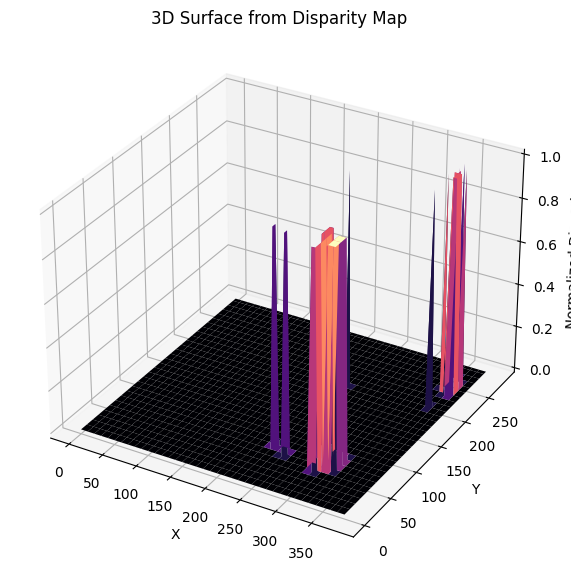

(3.258472583912037, '/mnt/data/disparity_map_normalized.npy')

In [44]:
# Preparar para la visualización 3D del mapa de disparidad
h, w = disparity_map.shape
x, y = np.meshgrid(np.arange(w), np.arange(h))

# Normalizar el mapa de disparidad para la visualización 3D
disparity_map_normalized = cv.normalize(disparity_map, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX)

# Configurar la densidad de puntos para la trama 3D
decimation = 5
x2 = x[::decimation, ::decimation]
y2 = y[::decimation, ::decimation]
z2 = disparity_map_normalized[::decimation, ::decimation]

# Generar la superficie 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x2, y2, z2, cmap='magma', edgecolor='none')

# Añadir etiquetas y ajustes finales
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Normalized Disparity')
ax.set_title('3D Surface from Disparity Map')
plt.show()

# Guardar resultados y rutas para compartir
mean_disparity, disparity_map_normalized_filepath = mean_disparity, '/mnt/data/disparity_map_normalized.npy'

mean_disparity, disparity_map_normalized_filepath